In [ ]:
! git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
! pip install -e ./Ranger-Deep-Learning-Optimizer/

Cloning into 'Ranger-Deep-Learning-Optimizer'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 135 (delta 34), reused 19 (delta 6), pack-reused 69
Receiving objects: 100% (135/135), 181.12 KiB | 6.04 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Obtaining file:///content/Ranger-Deep-Learning-Optimizer
  Running setup.py develop for ranger


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import math
import os
import matplotlib.pyplot as plt
from torchvision import transforms  

from fastai.vision import *
from fastai import *
from ranger import Ranger

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loader

In [ ]:
path = Path("/content/drive/My Drive/FaceAge")
path.ls()

[PosixPath('/content/drive/My Drive/FaceAge/train'),
 PosixPath('/content/drive/My Drive/FaceAge/models'),
 PosixPath('/content/drive/My Drive/FaceAge/FaceAge-Resnet18s64.pkl'),
 PosixPath('/content/drive/My Drive/FaceAge/FaceAge-Resnet34.pkl'),
 PosixPath('/content/drive/My Drive/FaceAge/FaceAge-Desenet121.pkl'),
 PosixPath('/content/drive/My Drive/FaceAge/test')]

In [ ]:
train_path = path/'train'

In [ ]:
def extract_age(filename):
    return float(filename.stem.split('_')[1])

In [ ]:
def load_face_data(img_size, batch_size):
    # Augmentation
    tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=7.5, max_lighting=0.15, max_warp=0.1,
                           p_affine=0.8, p_lighting = 0.8, 
                           xtra_tfms= [
                               pad(mode='zeros'),
                               symmetric_warp(magnitude=(-0.1,0.1)),
                               cutout(n_holes=(1,3), length=(4,4))]
                          )
    
    return (ImageList.from_folder(path)
            .random_split_by_pct(0.15, seed=22)
            .label_from_func(extract_age, label_cls=FloatList)
            .transform(tfms, size=img_size)
            .databunch(bs=batch_size))

# using 15% of training data for validation

# Resnet34

In [ ]:
class AgeModel2(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(models.resnet34(pretrained=True).children())[:-2]
        layers += [AdaptiveConcatPool2d(),Flatten()]
        layers += [nn.Linear(1024, 32), nn.GELU(), nn.Linear(32,1)]
        self.agemodel = nn.Sequential(*layers)
    def forward(self, x):
        return self.agemodel(x).squeeze()

### What is special about My Network? 
- using AdaptiveConcatPool2d() --> concats AdaptiveAvgPool2d and AdaptiveMaxPool2d
- Using GELU instead of ReLU in the fully connected layer

https://mlfromscratch.com/activation-functions-explained/#/

In [ ]:
learn = Learner(data, AgeModel2(), opt_func = Ranger, metrics=rmse).to_fp16() 
# using Mixed Precision (fp16) to speeding up computation

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# I found that img_size of 128 is the best size for this dataset to finetune!
img_size = 128
bs = 64
data = load_face_data(img_size, bs)
# normalize image by ImageNet stats
data.normalize(imagenet_stats)

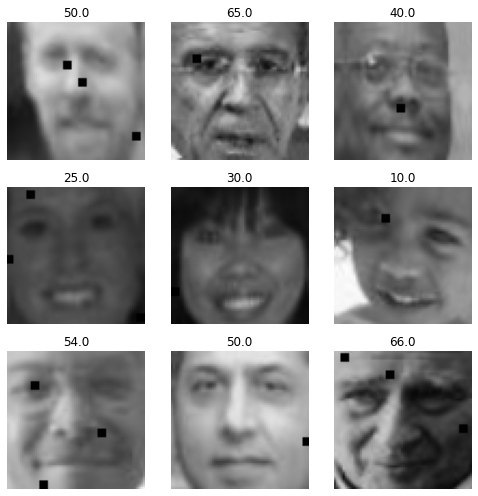

In [ ]:
data.show_batch(rows=3, figsize=(7,7))

# Start Training

In [ ]:
learn = Learner(data, AgeModel2(), opt_func = Ranger, metrics=rmse).to_fp16()
# using ranger optimizer!!

Detail about Ranger can be found here!

https://lessw.medium.com/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d

## Freeze Conv Layers

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,root_mean_squared_error,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 7.59E-02


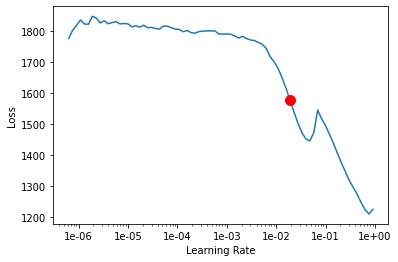

In [ ]:
# find a good learning rate for training
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_last=1)

https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6

In [ ]:
learn.fit_one_cycle(10, 1e-2)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,277.043884,148.123703,12.079334,00:50
1,149.349274,112.745255,10.562120,00:49
2,138.885147,195.720490,13.925293,00:49
3,125.496635,102.941483,10.089833,00:49
4,116.793465,108.815903,10.386588,00:49
5,107.088150,96.405327,9.763730,00:49
6,97.493088,96.746941,9.763232,00:49
7,84.563103,90.941132,9.484980,00:49
8,75.500061,86.630531,9.251275,00:49
9,69.227646,85.527321,9.191972,00:49


In [ ]:
learn.save('RN34-s128-freeze')

## Unfreeze Conv Layers

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,root_mean_squared_error,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.58E-07


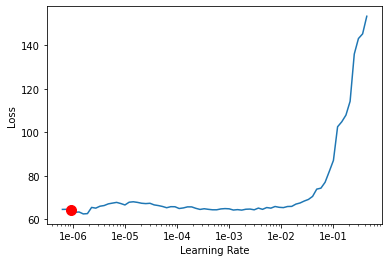

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_last=2)

In [ ]:
# weight decay ratio (wd) of 0.01 
# Dropout Ratio (pct_start) of 0.3 
learn.fit_one_cycle(20, 1e-4, wd=0.01, pct_start=0.3)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,64.676895,85.276413,9.178766,00:50
1,67.670792,85.767136,9.202364,00:49
2,65.767578,84.924927,9.157912,00:50
3,66.470604,85.482719,9.187932,00:50
4,65.327843,85.732620,9.197228,00:50
5,65.591187,84.758553,9.146073,00:50
6,63.287148,84.166588,9.112885,00:49
7,62.404594,84.670113,9.139247,00:49
8,63.700886,84.936119,9.159053,00:49
9,60.655392,84.482445,9.132236,00:49


In [ ]:
learn.save('RN34-s128-unfreeze')

## Examples of Validation Predictions

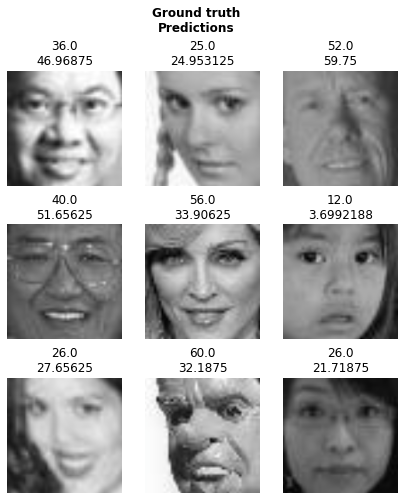

In [ ]:
learn.show_results(rows=3, figsize=(7,8))

In [ ]:
# Export the model for Usage Prediction
learn.export(path/'FaceAge-Resnet34.pkl') 

# Evaluation on Competition Set

In [ ]:
import natsort 

In [ ]:
class AgeModel2(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(models.resnet34(pretrained=True).children())[:-2]
        layers += [AdaptiveConcatPool2d(),Flatten()]
        layers += [nn.Linear(1024, 32), nn.GELU(), nn.Linear(32,1)]
        self.agemodel = nn.Sequential(*layers)
    def forward(self, x):
        return self.agemodel(x).squeeze()

In [ ]:
test_path = path/'test'

In [ ]:
# sort image files
test_path_sort = natsort.natsorted(test_path.ls(), key=str)   

In [ ]:
resnet_inf = load_learner(path, 'FaceAge-Resnet34.pkl').to_fp32()
resnet_inf.data.add_test(items=test_path_sort, tfms=None, tfm_y=False)

In [ ]:
pred1 = resnet_inf.get_preds(ds_type=DatasetType.Test)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [ ]:
# Check min and max values of predictions
# --> great that our predictions are all positive!!
pred1[0].min(), pred1[0].max()

(tensor(0.9406), tensor(76.8237))

In [ ]:
# save a 1D vector yhat as an npy file
with open(path/'y_pred_res34.npy', 'wb') as f:
    np.save(f, np.array(pred1[0]).reshape(-1,))

### Additional Research of Ages (Distribution Plots!)

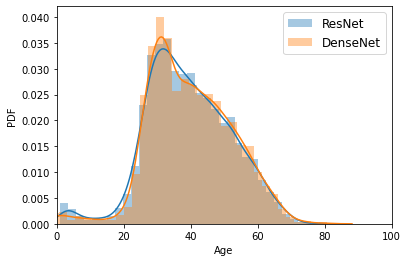

In [ ]:
# note that I also try this with DenseNet121; however, the result is not better than ResNet34 (validation)
# using Ensemple Learning of these 2 models improve validation RMSE to about 0.9 (didn't submit this version)
# ::  Ensemple_pred = 0.6*y_resnet + 0.4*y_densenet

# check the distributions of model predictions of the competition faces
sns.distplot(np.array(pred1[0]).reshape(-1,),  kde=True, label='ResNet')
sns.distplot(np.array(pred2[0]).reshape(-1,), kde=True, label='DenseNet')
plt.xlim(0,100)
plt.xlabel('Age')
plt.ylabel('PDF')
plt.legend(prop={'size': 12})
plt.show()

# we can see that the distributions of our predictions are quite similar to the distribution of Ytrain (cell below)
# which means our predictions are reliable. 

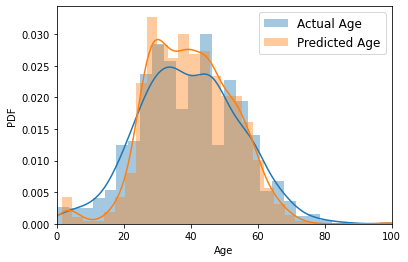

In [ ]:
# distributions of Training Faces 

sns.distplot(y_test,  kde=True, label='Actual Age')
sns.distplot(nppreds, kde=True, label='Predicted Age')
plt.xlim(0,100)
plt.xlabel('Age')
plt.ylabel('PDF')
plt.legend(prop={'size': 12})
plt.show()

In [ ]:
## Note that I trasnform the npy format to JPG images and save them in RGB format before training the model!